SAS & HSE, Applied Time Series Forecasitng , Fall 2021 

<font color="blue"> Lesson #2: Simple Exponential Smoothing Model </font>

<span style="color:black; font-size: 12pt"></span>

Alexey Romanenko,
<font color="blue">alexromsput@gmail.com</font>

**Key words:** simple exponential smoothing, adaptive exponential smoothing, retail time series

**Your fitback:**  please provide you feedback  <a href="https://forms.gle/bEV5iwmTqdM9rUoy8"> here </a>

In [2]:
import numpy as np
from datetime import datetime, timedelta
import pylab
import matplotlib.pyplot as plt
import pandas as pd
import math
import pandas.tseries.offsets as ofs
import warnings as w
from matplotlib import gridspec
# import plotly.plotly as py
import seaborn as sns

from IPython.display import Image

%matplotlib inline

# Typical TS for SES Model

## TS in Retail

In [3]:
ts = pd.read_csv('https://raw.githubusercontent.com/aromanenko/ATSF/main/data/retail_10ts.csv', parse_dates=['Dates'], dayfirst=True, index_col='Dates')
ts.index.names=['Timestamp']
ts = ts.sort_index() # sort index
ts.head()

,Item: 165,Item: 969,Item: 2653,Item: 2654,Item: 2692,Item: 2695,Item: 2697,Item: 2765,Item: 2767,Item: 2806,Item: 2808
Timestamp,,,,,,,,,,,
2005-01-11,NaN,2.0,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2005-01-12,NaN,5.0,8.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2005-01-13,NaN,2.0,20.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2005-01-14,NaN,42.0,14.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2005-01-15,NaN,NaN,23.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [4]:
# Interval of ts 
ts.loc['2007-01-01':'2007-01-05']

,Item: 165,Item: 969,Item: 2653,Item: 2654,Item: 2692,Item: 2695,Item: 2697,Item: 2765,Item: 2767,Item: 2806,Item: 2808
Timestamp,,,,,,,,,,,
2007-01-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2007-01-02,NaN,21.0,11.0,NaN,7.0,2.0,NaN,7.0,1.0,3.0,5.0
2007-01-03,NaN,10.0,15.0,NaN,21.0,7.0,NaN,2.0,3.0,0.0,2.0
2007-01-04,NaN,NaN,4.0,NaN,7.0,NaN,NaN,12.0,1.0,NaN,1.0
2007-01-05,NaN,3.0,36.0,NaN,14.0,NaN,NaN,6.0,10.0,4.0,1.0


**Questions** 
    - Which charachteristic of TS can you mention so far?
    - Which components of TS can you see?

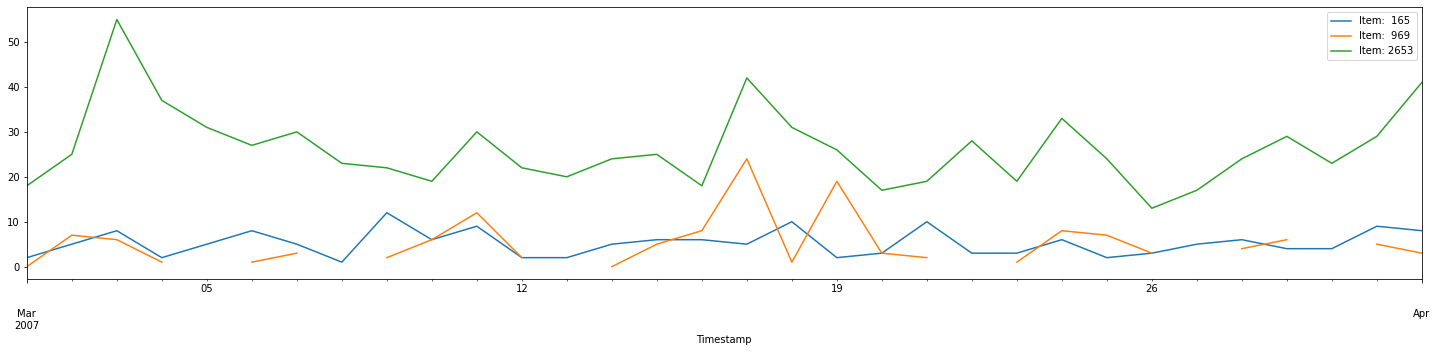

In [5]:
# fig = plt.figure()
ts.loc['2007-03-01':'2007-04-01', ts.columns[range(3)]].plot(figsize=(25,5))
# to save the pictures
# plt.savefig('../Lecture_TS_Forecasting/pic/TS_Example.eps', bbox_inches='tight', pad_inches=0, format='eps', dpi=1000) 

**Questions**

 - What are key aspects of these retail ts?


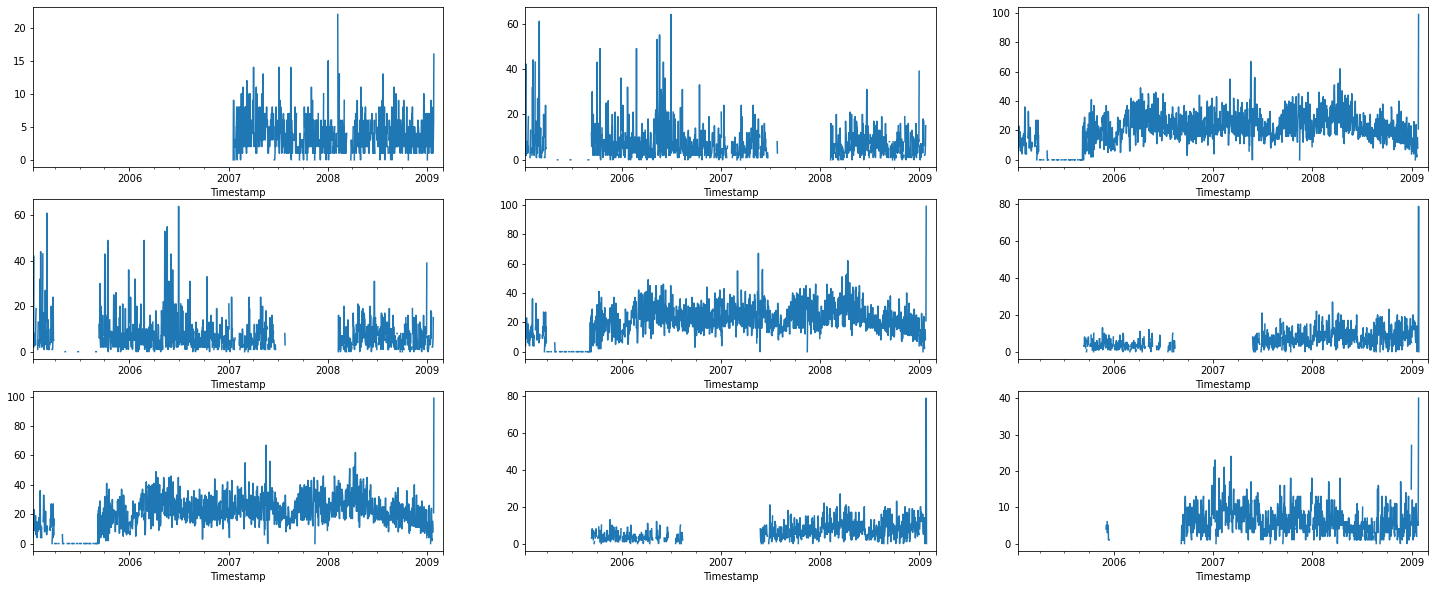

In [6]:
fig = plt.figure(figsize=(25,10))
gs = gridspec.GridSpec(3, 3)
for i in range(3):
    for j in range(3):
        fig.add_subplot(gs[i,j])
        ts.loc[:, ts.columns[i+j]].plot()

**Questions**

 - Any idea how to predict such ts?
 - Can you describe statistical model for such ts?

###### Answer



$$y_{t} = l_t + \color{red}{\varepsilon_t},$$

where $l_t$ $-$ changing slowly level of time series,

$\varepsilon_t~-$ error component (unobserved noise)

Forecasting model:

$$ {\hat y_{t+d}} = \color{\red}{\hat l_t} $$

where $\hat l_t~-$ an estimation of level


## Moving Average

** Rolling window n **
       $$\hat y_{t+d} = \frac{1}{n}\left(y_{t-n}+\dots+ {y}_t\right)$$
   
** All points in  $[t-n, t]$ has the same weight **
                                   $$w = \frac{1}{n}$$
** Other points has weight**
                                    $$w = 0$$

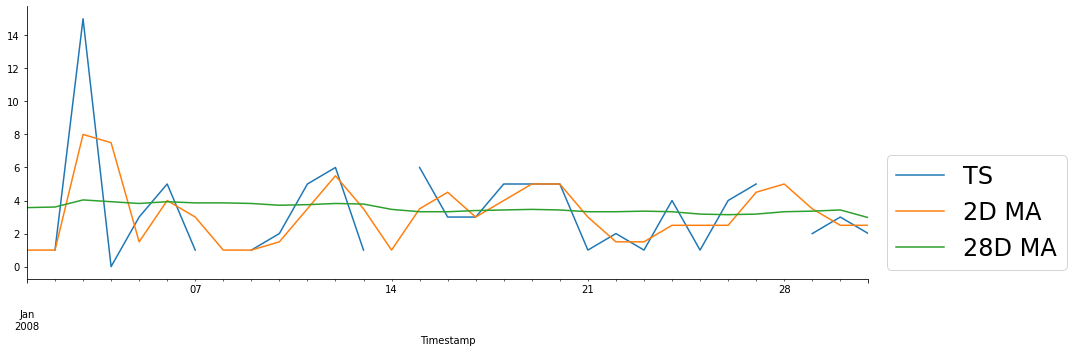

In [7]:
# Rolling moving (n = 2 и n=28)
# Note: replace NaN befor average calculation
ts.loc['2008-01-01':'2008-01-31'][u'Item:  165'].plot(label='TS')
ts[u'Item:  165'].fillna(method='pad').rolling(2).mean().loc['2008-01-01':'2008-01-31'].plot(label='2D MA', figsize=(15,5))
ts[u'Item:  165'].fillna(method='pad').rolling(28).mean().loc['2008-01-01':'2008-01-31'].plot(label='28D MA', figsize=(15,5))

plt.legend(bbox_to_anchor=(1.25, .5), prop={'size':24})
plt.tight_layout()
sns.despine()

**Expanding window**
       $$\hat y_{t+d} = \frac{1}{t}\left(y_{1}+\dots+ {y}_t\right)$$
   
**All time points in $[1, t]$ has the same weight**
                                   $$w = \frac{1}{t}$$   

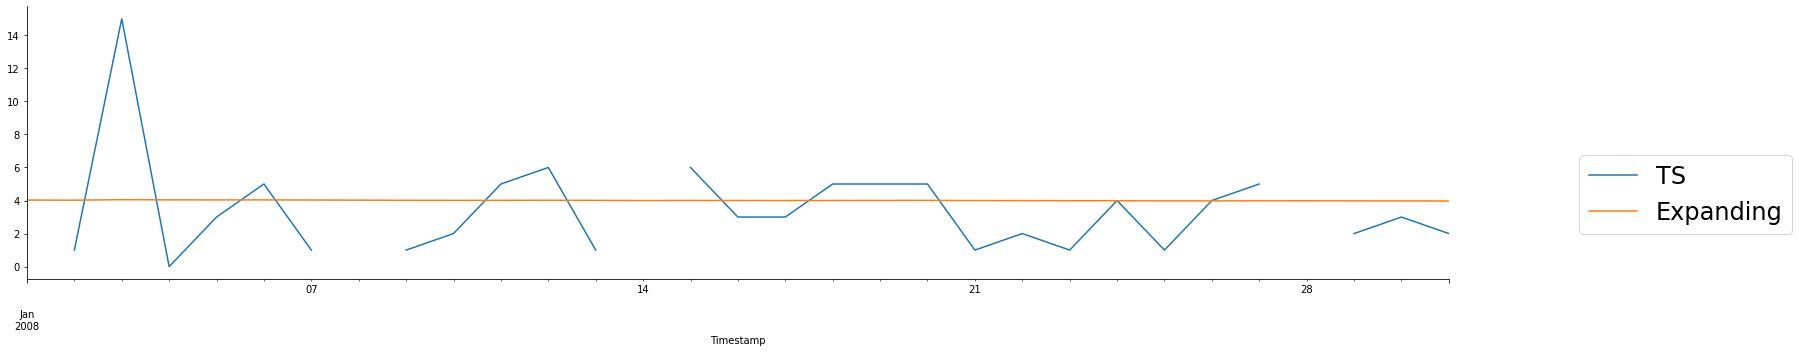

In [8]:
# Expanding windod
ts.loc['2008-01-01':'2008-01-31'][u'Item:  165'].plot(label='TS')
ts.fillna(method='pad')[u'Item:  165'].expanding().mean().loc['2008-01-01':'2008-01-31'].plot(label='Expanding', figsize=(25,5))

plt.legend(bbox_to_anchor=(1.25, .5), prop={'size':24})
plt.tight_layout()
sns.despine()

**Questions**

 - What are analytical disadvantages of using movinag average algorithm?


## Exponentially Wighted Moving Average

**Exponentialy diminishing weights**
    $$\hat y_{t+d}= \alpha y_t + \alpha \left(1-\alpha\right)y_{t-1} + \alpha \left(1-\alpha\right)^2y_{t-2}+\dots = \sum_{\tau=1}^t \alpha\cdot (1-\alpha)^{t-\tau}\cdot y_\tau$$
   
**Weight for time point in moment $\tau$**
    $$w_\tau = \alpha\cdot (1-\alpha)^{t-\tau}$$  


In [17]:
# look at timestamp weights
t = 10
alpha_set = [0.001, 0.1, 0.2, 0.5, 0.9]
pd.DataFrame(data = [[a*(1-a)**(t-tau) for a in alpha_set] for tau in range(1,t+1,1)], columns = [r'\alpha=' + str(x) for x in alpha_set], index = range(1,t+1,1)).sort_index(ascending = False)

,\alpha=0.001,\alpha=0.1,\alpha=0.2,\alpha=0.5,\alpha=0.9
10,0.001000,0.100000,0.200000,0.500000,9.000000e-01
9,0.000999,0.090000,0.160000,0.250000,9.000000e-02
8,0.000998,0.081000,0.128000,0.125000,9.000000e-03
7,0.000997,0.072900,0.102400,0.062500,9.000000e-04
6,0.000996,0.065610,0.081920,0.031250,9.000000e-05
5,0.000995,0.059049,0.065536,0.015625,9.000000e-06
4,0.000994,0.053144,0.052429,0.007812,9.000000e-07
3,0.000993,0.047830,0.041943,0.003906,9.000000e-08
2,0.000992,0.043047,0.033554,0.001953,9.000000e-09
1,0.000991,0.038742,0.026844,0.000977,9.000000e-10


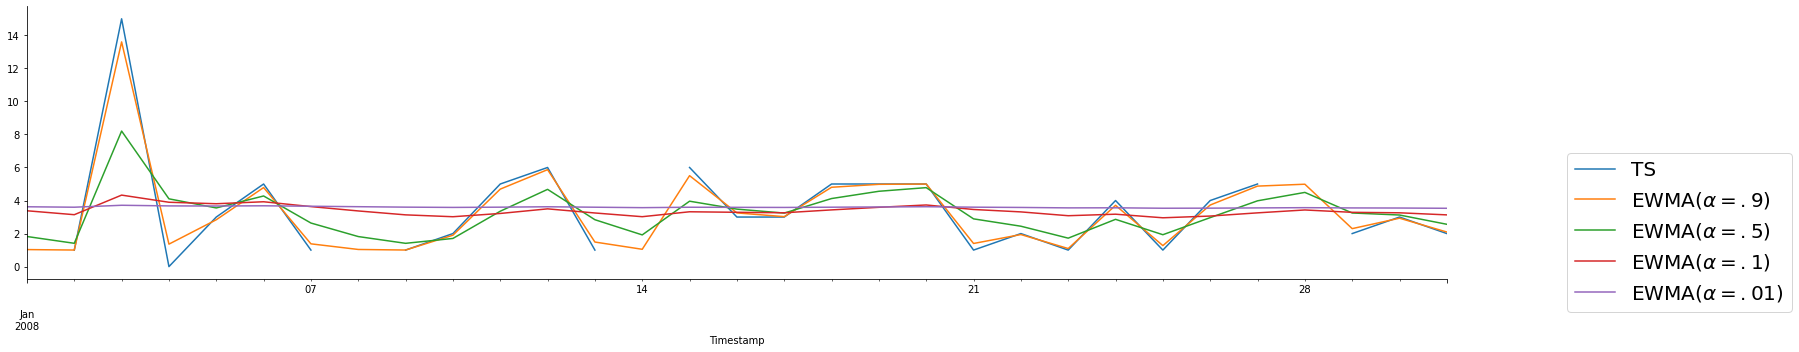

In [11]:
# Averaging with exponential weights
ts.loc['2008-01-01':'2008-01-31'][u'Item:  165'].plot(label='TS')
ts.fillna(method='pad')[u'Item:  165'].ewm(alpha=0.9).mean().loc['2008-01-01':'2008-01-31'].plot(label='EWMA($\\alpha=.9$)') 
ts.fillna(method='pad')[u'Item:  165'].ewm(alpha=0.5).mean().loc['2008-01-01':'2008-01-31'].plot(label='EWMA($\\alpha=.5$)') 
ts.fillna(method='pad')[u'Item:  165'].ewm(alpha=0.1).mean().loc['2008-01-01':'2008-01-31'].plot(label='EWMA($\\alpha=.1$)') 
ts.fillna(method='pad')[u'Item:  165'].ewm(alpha=0.01).mean().loc['2008-01-01':'2008-01-31'].plot(label='EWMA($\\alpha=.01$)', figsize=(25,5)) 

plt.legend(bbox_to_anchor=(1.25, .5), prop={'size':20})
plt.tight_layout()
sns.despine()

**Parameter $\alpha$ drives the depth of the historical period to be considered!**

$\alpha \uparrow 1 \; \Rightarrow$ EWMA is closer to Moving Average with window = 1,

$\alpha \downarrow 0 \; \Rightarrow$ EWMA is closer to Moving Average with expanding window.

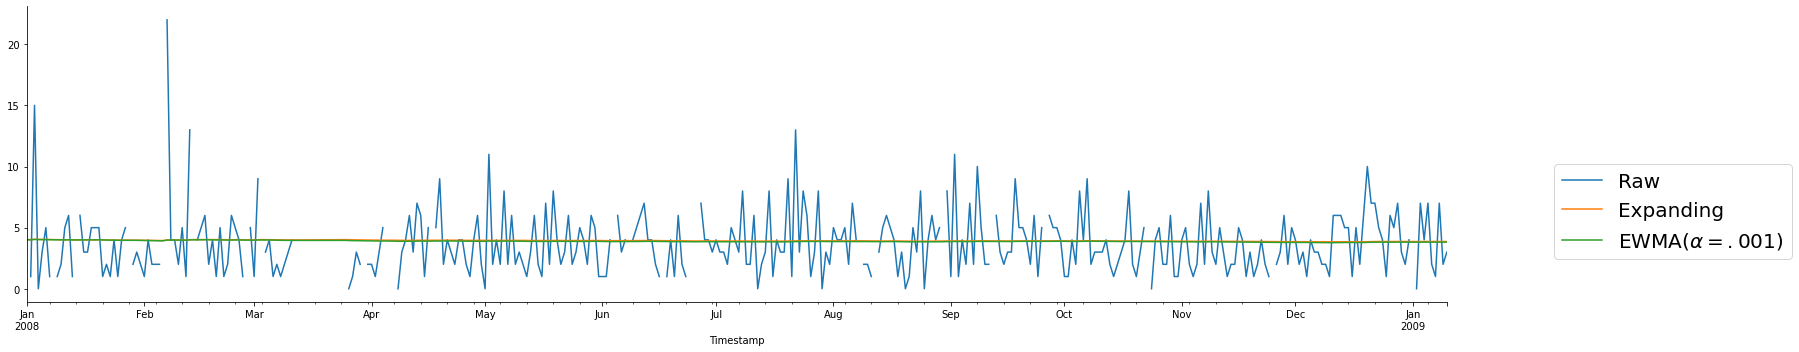

In [18]:
# Compare EWMA (alpha = 0.001) and Expanding 
ts.loc['2008-01-01':'2009-01-10'][u'Item:  165'].plot(label='Raw')
ts[u'Item:  165'].fillna(method='pad').expanding().mean().loc['2008-01-01':'2009-01-10'].plot(label='Expanding')
ts[u'Item:  165'].ewm(alpha=0.001).mean().loc['2008-01-01':'2009-01-10'].plot(label='EWMA($\\alpha=.001$)', figsize=(25,5)) 

plt.legend(bbox_to_anchor=(1.25, .5), prop={'size':20})
plt.tight_layout()
sns.despine()

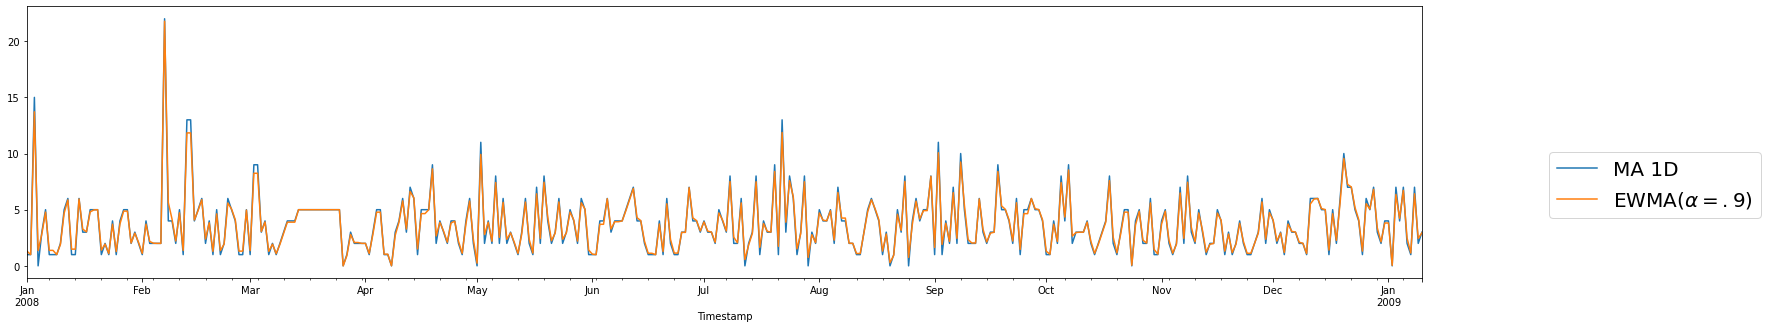

In [19]:
# Compare EWMA (alpha = 0.9) and MA (window = 1) 
# ts.loc['2008-01-01':'2009-01-10'][u'Item:  165'].plot(label='Raw')
ts[u'Item:  165'].fillna(method='pad').rolling(1).mean().loc['2008-01-01':'2009-01-10'].plot(label='MA 1D')
ts[u'Item:  165'].ewm(alpha=0.9).mean().loc['2008-01-01':'2009-01-10'].plot(label='EWMA($\\alpha=.9$)', figsize=(25,5)) 
plt.legend(bbox_to_anchor=(1.25, .5), prop={'size':20})

# Simple Exponential Smoothing

## A bit of Theory

**Sum notation**:
$$\hat{y}_{t+d} = \sum_{\tau=1}^t \alpha\cdot (1-\alpha)^{t-\tau}\cdot y_\tau~~~~~(1)$$ 

**Question:**
 * What is the problem with this formla (1)?
 * Hint: calculate sum of weights of time series points.

**Recurrent formula notation:**
$$\hat{y}_{t+d} = \alpha\cdot y_t+ (1-\alpha)\cdot \hat{y}_t = \hat y_t + \alpha \cdot \color{red}{e_t}$$




## SES Realization

In [20]:
# Example of realization

# Simple Exponential Smoothing
# x <array Tx1>- time series, 
# h <scalar> - forecasting delay
# Params <dict> - dictionary with 
#    alpha <scalar in [0,1]> - smoothing parameter

def SimpleExponentialSmoothing(x, h=1, Params={}):
    T = len(x)
    alpha = Params['alpha']
    FORECAST = [np.NaN]*(T+h)
    if alpha>1:
        w.warn('Alpha can not be more than 1')
        #alpha = 1
        return FORECAST
    if alpha<0:
        w.warn('Alpha can not be less than 0')
        #alpha = 0
        return FORECAST
    y = x[0]
    for cntr in range(T):
        if not math.isnan(x[cntr]):
            if math.isnan(y):
                y=x[cntr]
            y = y*(1-alpha) + alpha*x[cntr]
            #else do not nothing
        FORECAST[cntr+h] = y
    return FORECAST

In [21]:
# Forecast delay = 1
h = 1
start = ts.index[-1]+timedelta(1)
end = ts.index[-1]+timedelta(h)
rng = pd.date_range(start, end)
frc_ts = pd.DataFrame(index = ts.index.append(rng), columns = ts.columns)

In [22]:
# ES params
Params ={'alpha':0.1}

# generate forecasts for each Item
for cntr in ts.columns:
    frc_ts[cntr] = SimpleExponentialSmoothing(ts[cntr], h, Params)

In [23]:
# fig = plt.figure(figsize=(25,7))
# ax1=fig.add_subplot(111)
# qlt_array=['SSE', 'MSE', 'RMSE', 'MedianAE', 'MAPE', 'MACAPE']
# for i in range(6):
#     # Quality = [np.NaN]*len(ts.columns)
#     plt.subplot(2,3,i+1)
#     Quality, _ = eval('quality'+qlt_array[i])(ts, frc_ts)
#     Quality.plot(kind='bar')
#     plt.title(qlt_array[i], y=0.9)

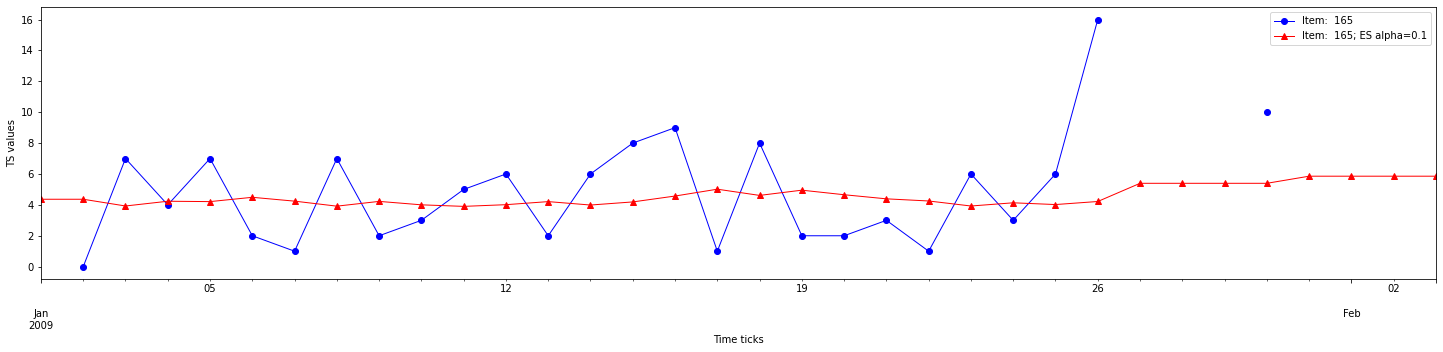

In [28]:
# show SES forecast alpha = 0.1
def plotTSForecast(ts, frc_ts, ts_num=0, alg_title=''):
    frc_ts.columns = ts.columns+'; '+alg_title
    ts[ts.columns[0]].plot(style='b', linewidth=1.0, marker='o')
    ax = frc_ts[frc_ts.columns[ts_num]].plot(style='r-^', figsize=(25,5), linewidth=1.0)
    plt.xlabel("Time ticks")
    plt.ylabel("TS values")
    plt.legend()
    return ax

plotTSForecast(ts.loc['2009-01-01':'2009-02-03'], frc_ts.loc['2009-01-01':'2009-02-03'], ts_num=0, alg_title='ES alpha=0.1')

**Question:**
 * Why the forecasts values for 27th, 28th, 29th and 30th of January are the same?
 * When does the last change of the forecast value occur?  

In [29]:
# Generate forecast for h = 30
h = 30
start = ts.index[-1]+timedelta(1)
end = ts.index[-1]+timedelta(h)
rng = pd.date_range(start, end)
frc_ts = pd.DataFrame(index = ts.index.append(rng), columns = ts.columns)

for cntr in ts.columns:
    frc_ts[cntr] = SimpleExponentialSmoothing(ts[cntr], h, {'alpha':0.1})

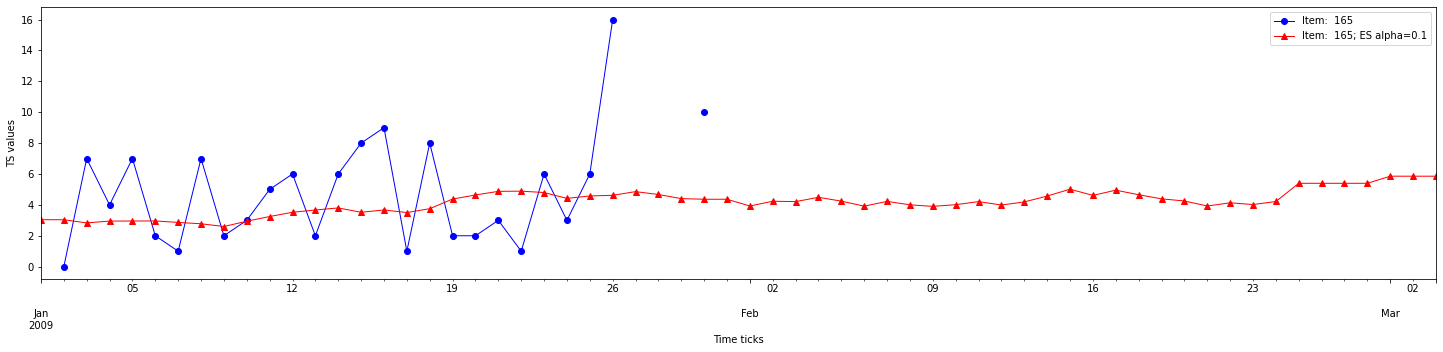

In [30]:
# show forecast h = 30, alpha = 0.1
plotTSForecast(ts.loc['2009-01-01':'2009-03-03'], frc_ts.loc['2009-01-01':'2009-03-03'], ts_num=0, alg_title='ES alpha=0.1')

## Search for the optimal $\alpha$ 

In [31]:
def build_forecast(h, ts, AlgName, AlgTitle, ParamsArray, step='D'):
  'grid'
    
  FRC_TS = dict()

  for p in ParamsArray:
      frc_horizon = pd.date_range(ts.index[-1], periods=h+1, freq=step)[1:]
      frc_ts = pd.DataFrame(index = ts.index.append(frc_horizon), columns = ts.columns)
      
      for cntr in ts.columns:
          frc_ts[cntr] = eval(AlgName)(ts[cntr], h, p)
          # frc_ts[cntr] = AlgName(ts[cntr], h, p)
      
#         frc_ts.columns = frc_ts.columns+('%s %s' % (AlgTitle, p))
      FRC_TS['%s %s' % (AlgTitle, p)] = frc_ts
  
  return FRC_TS

In [32]:
#Fit parameters
ALPHA = [0.7, 0.4, 0.2, .15, 0.1, 0.05, 0.01]
ESParamsArray = [{'alpha':alpha} for alpha in ALPHA]
FRC_TS = build_forecast(h=1, ts=ts, AlgName =  'SimpleExponentialSmoothing', AlgTitle='ES' ,ParamsArray = ESParamsArray)

### Loss of the SES forecast for all history

In [87]:
# intoduce loss function
def qualityMAPE(x,y):
    # Mean absolute percentage error
    # x,y - pandas structures
    # x - real values
    # y - forecasts
  qlt = ((x-y).abs()/x).replace([np.inf, -np.inf], np.nan)
  return qlt.mean() , (x-y).abs()

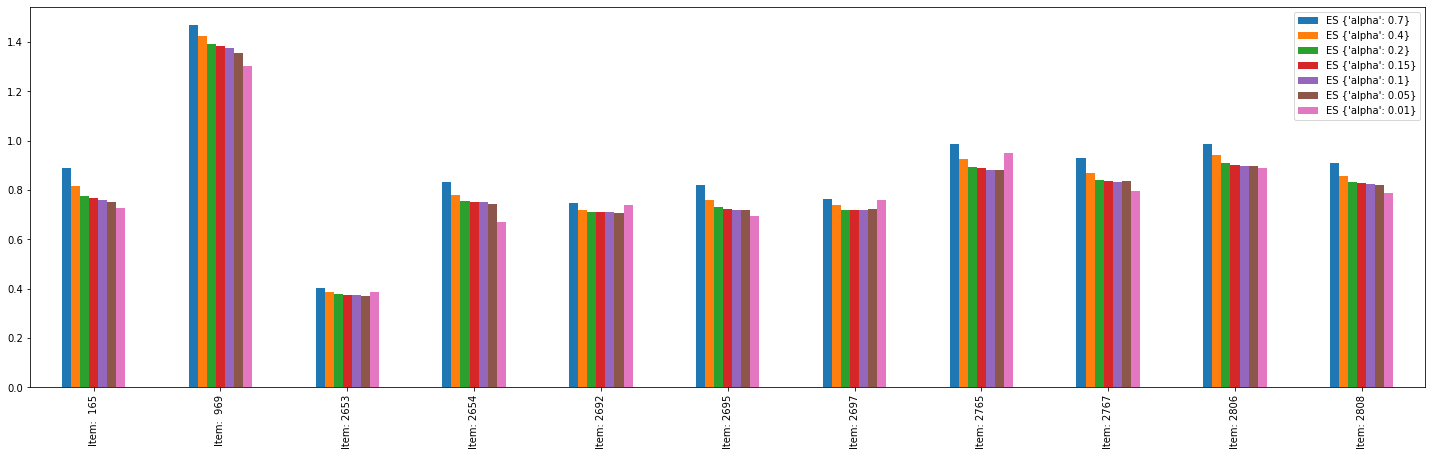

In [100]:
# compare ES parameters
quality_wholehist = pd.DataFrame(index = ts.columns, columns = FRC_TS.keys())

# Quality within all 1500 steps
for param_cntr in sorted(quality_wholehist.columns):
    frc_ts = FRC_TS[param_cntr]
    quality_wholehist[param_cntr],_ = qualityMAPE(ts, frc_ts.loc[ts.index])

ax = quality_wholehist.plot.bar(figsize = (25,7))

* The optimal value of $\alpha$ is about $0.1$ 

### Loss for first time series point

Text(0, 0.5, 'MAPE')

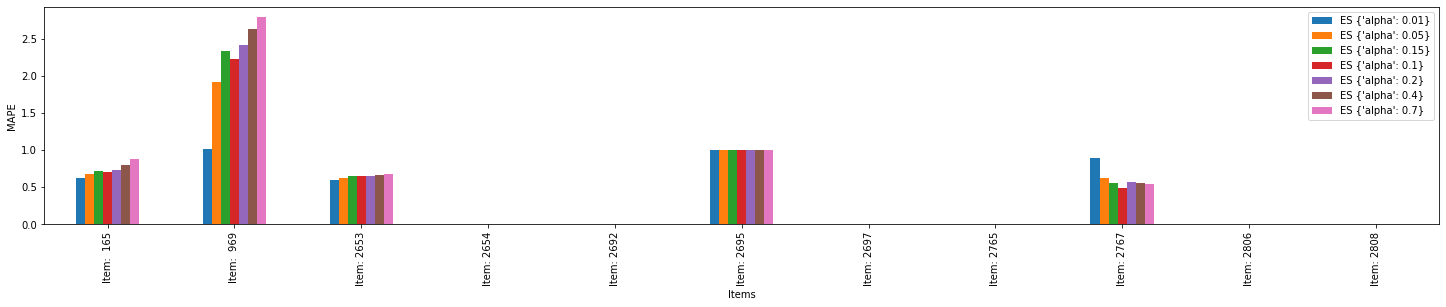

In [94]:
quality_initphase = pd.DataFrame(index = ts.columns, columns = FRC_TS.keys())

# Quality in first 100 steps
init_steps = 100
for model in quality_initphase.columns:
    frc_ts = FRC_TS[model]
    for ts_num in ts.columns:
        ix = pd.date_range(ts[ts_num].first_valid_index(), ts[ts_num].first_valid_index()+timedelta(init_steps))
        quality_initphase[model][ts_num],_ = qualityMAPE(ts[ts_num].loc[ix], frc_ts[ts_num].loc[ix])

ax = quality_initphase[sorted(quality_initphase.columns)].plot.bar(figsize = (25,4))
ax.set_xlabel("Items")
ax.set_ylabel("MAPE")

**Question:**

Why is loss function  not calculated for some items?

(Hint: see definition of loss function)

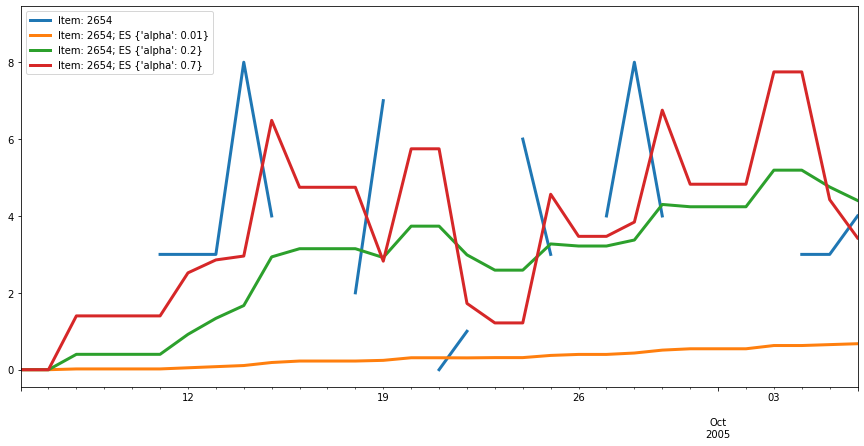

In [72]:
# ts VS forecast in first 100 steps
model_num = [0,4,6]  # [0,6], [0,4,6]
Models = sorted(FRC_TS.keys())

ts_num = 3 # 7
plot_ts = pd.DataFrame(index =ts.index)
plot_ts[ts.columns[ts_num]] = ts[ts.columns[ts_num]]
for model in model_num:
     frc_ts = FRC_TS[Models[model]]
     plot_ts[frc_ts.columns[ts_num]+'; '+Models[model]] = frc_ts[frc_ts.columns[ts_num]]

ix = pd.date_range(ts[ts.columns[ts_num]].first_valid_index()+timedelta(140), ts[ts.columns[ts_num]].first_valid_index()+timedelta(170))
plot_ts.loc[ix].plot(figsize = (15, 7), linewidth=3.0) # :250

**Wow: we need to use big $\alpha$ for first steps of ES!** 
    - We need to modify algorithm for tirst steps!

**Question:**
   * How algorithm can be modified for first steps?

## Examples of modification (self-study)

* First variant: let's make $\alpha$ higher for first time point of TS

In [ ]:
def InitExponentialSmoothing(x, h, Params):
    T = len(x)
    alpha = Params['alpha']
    AdaptationPeriod=Params['AdaptationPeriod']
    FORECAST = [np.NaN]*(T+h)
    if alpha>1:
        w.warn('Alpha can not be more than 1')
        #alpha = 1
        return FORECAST
    if alpha<0:
        w.warn('Alpha can not be less than 0')
        #alpha = 0
        return FORECAST
    y = x[0]
    t0=0
    for t in range(0, T):
        if not math.isnan(x[t]):
            if math.isnan(y):
                y=x[t]
                t0=t
            if (t-t0+1)<AdaptationPeriod:
                y = y*(1-alpha)*(t-t0+1)/(AdaptationPeriod) + (1-(1-alpha)*(t-t0+1)/(AdaptationPeriod))*x[t]
            else:
                y = y*(1-alpha) + alpha*x[t]
            #else do not nothing
        FORECAST[t+h] = y
    return FORECAST

* Second variant: normalize weights of ES: $1 - (1-\alpha)^t$

In [ ]:
def NormExponentialSmoothing(x, h, Params):
    T = len(x)
    alpha = Params['alpha']
    FORECAST = [np.NaN]*(T+h)
    if alpha>1:
        w.warn('Alpha can not be more than 1')
        #alpha = 1
        return FORECAST
    if alpha<0:
        w.warn('Alpha can not be less than 0')
        #alpha = 0
        return FORECAST
    
    y = 0
    norm = 0
    for t in range(0, T):
        if not math.isnan(x[t]):
            if math.isnan(y):
                norm=1  # initialize when first data point comes
            norm = norm*(1-alpha)
            y = y*(1-alpha) + (alpha)*x[t]
        FORECAST[t+h] = y/(1-norm)
    return FORECAST

In [ ]:
#Fit parameters

ALPHA = [0.7, 0.4, 0.2, .15, 0.1, 0.05, 0.01]
ESParamsArray = [{'alpha':alpha, 'AdaptationPeriod': 5} for alpha in ALPHA]
FRC_TS.update(build_forecast(h=1, ts=ts, AlgName =  'InitExponentialSmoothing', AlgTitle='IES' ,ParamsArray = ESParamsArray))
FRC_TS.update(build_forecast(h=1, ts=ts, AlgName =  'NormExponentialSmoothing', AlgTitle='NES' ,ParamsArray = ESParamsArray))

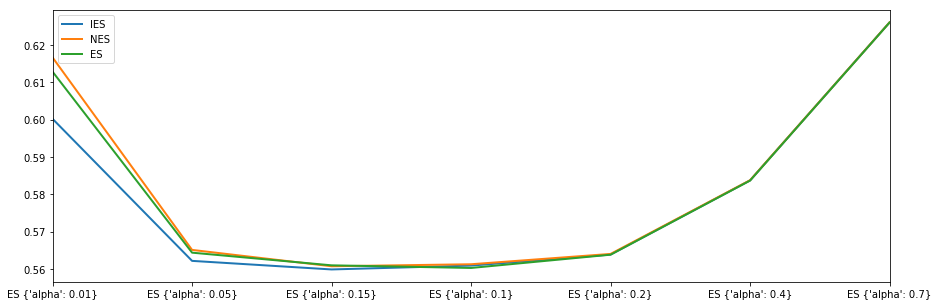

In [ ]:
# compare ES methods
QualityStr = pd.DataFrame(index = ts.columns, columns = sorted(FRC_TS.keys()))

for model in sorted(QualityStr.columns):
    frc_ts = FRC_TS[model]
    QualityStr[model],_ = qualityMACAPE(ts, frc_ts)


QualityStr[sorted(QualityStr.columns)[7:14]].mean().plot(label='IES', linewidth=2.0)
QualityStr[sorted(QualityStr.columns)[14:]].mean().plot(label='NES', linewidth=2.0)
QualityStr[sorted(QualityStr.columns)[:7]].mean().plot(label='ES', figsize = (15, 5),linewidth=2.0)
# ax.set_xticklabels(np.reshape(np.asarray(QualityStr.columns[:14]), (2, 7)).T , rotation=90)
plt.legend()

* Conclusion: **The optimal value of $\alpha$ is about the same for all ES modifications.**

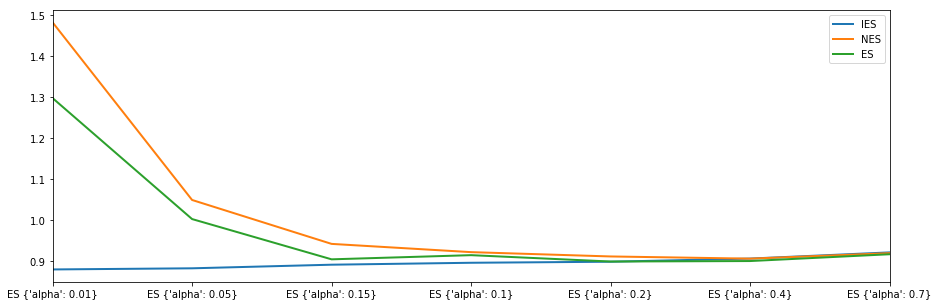

In [ ]:
# compare ES methods in first 100 steps
QualityStr = pd.DataFrame(index = ts.columns, columns = sorted(FRC_TS.keys()))

for model in QualityStr.columns:
    frc_ts = FRC_TS[model]
    for ts_num in ts.columns:
        ix = pd.date_range(ts[ts_num].first_valid_index(), ts[ts_num].first_valid_index()+timedelta(50))
        QualityStr[model][ts_num],_ = qualityMACAPE(ts[ts_num].loc[ix], frc_ts[ts_num].loc[ix])


QualityStr[sorted(QualityStr.columns)[7:14]].mean().plot(label='IES', linewidth=2.0)
QualityStr[sorted(QualityStr.columns)[14:21]].mean().plot(label='NES', linewidth=2.0)
QualityStr[sorted(QualityStr.columns)[:7]].mean().plot(label='ES',  figsize = (15, 5),linewidth=2.0)
plt.legend()

## Adaptive ES (self-studying)

### Tracking signal

$e_t = y_t - \hat{y}_t$

$\tilde{e}_t = \gamma e_{t-1} + (1-\gamma) \tilde{e}_{t-1}$

$\overline{e}_t = \gamma \left|e_{t-1}\right| + (1-\gamma) \overline{e}_{t-1}$

* Tracking signal

$$K_t = \frac{\tilde{e}_t}{\overline{e}_t}$$

* to do algorithm more stable 
$$\alpha_t = \left|K_{t-1}\right|$$

In [ ]:
# AdaptiveExponentialSmoothing
# x <array Tx1>- time series, 
# h <scalar> - forecasting delay
# Params <dict> - dictionary with 
#    alpha <scalar in [0,1]> - smoothing parameter
#    AdaptivePeriod scalar> - adapation period for initialization
#    gamma<scalar in [0,1]> - parametr of cross validation

def AdaptiveExponentialSmoothing(x, h, Params):
    T = len(x)
    alpha = Params['alpha']
    gamma = Params['gamma']
    AdaptationPeriod=Params['AdaptationPeriod']
    FORECAST = [np.NaN]*(T+h)
    if alpha>1:
        w.warn('Alpha can not be more than 1')
        #alpha = 1
        return FORECAST
    if alpha<0:
        w.warn('Alpha can not be less than 0')
        #alpha = 0
        return FORECAST
    y = np.NaN
    t0= np.NaN
    e1= np.NaN
    e2= np.NaN
    Kt_1 = alpha
    K=alpha
    for t in range(0, T):
        if not math.isnan(x[t]):
            if math.isnan(y):
                y=x[t]
                t0=t
                e1=alpha
                e2 = 1
            else:
                if (t-t0)<h:
                    e1 = gamma*(x[t]-y)+(1-gamma)*e1
                    e2 = gamma*np.abs(x[t]-y)+(1-gamma)*e2
                else:
                    e1 = gamma*(x[t]-FORECAST[t])+(1-gamma)*e1
                    e2 = gamma*np.abs(x[t]-FORECAST[t])+(1-gamma)*e2
            
            if e2==0:
                K=alpha
            else:
                K=np.abs(e1/e2)

            alpha=Kt_1
            Kt_1=K

            if (t-t0+1)<AdaptationPeriod:
                y = y*(1-alpha)*(t-t0+1)/(AdaptationPeriod) + (1-(1-alpha)*(t-t0+1)/(AdaptationPeriod))*x[t]
            else:
                y = y*(1-alpha) + (alpha)*x[t]
        FORECAST[t+h] = y
    return FORECAST

In [ ]:
#Fit parameters
GAMMA = [0.1, 0.01, 0.005, 0.001, 0.0005, 0.0001, 0.00005]
alpha = 0.1
AESParamsArray = [{'alpha':alpha, 'gamma':gamma, 'AdaptationPeriod': 5} for gamma in GAMMA]
FRC_TS.update(build_forecast(h=1, ts=ts, AlgName =  'AdaptiveExponentialSmoothing', AlgTitle='AES' ,ParamsArray = AESParamsArray))

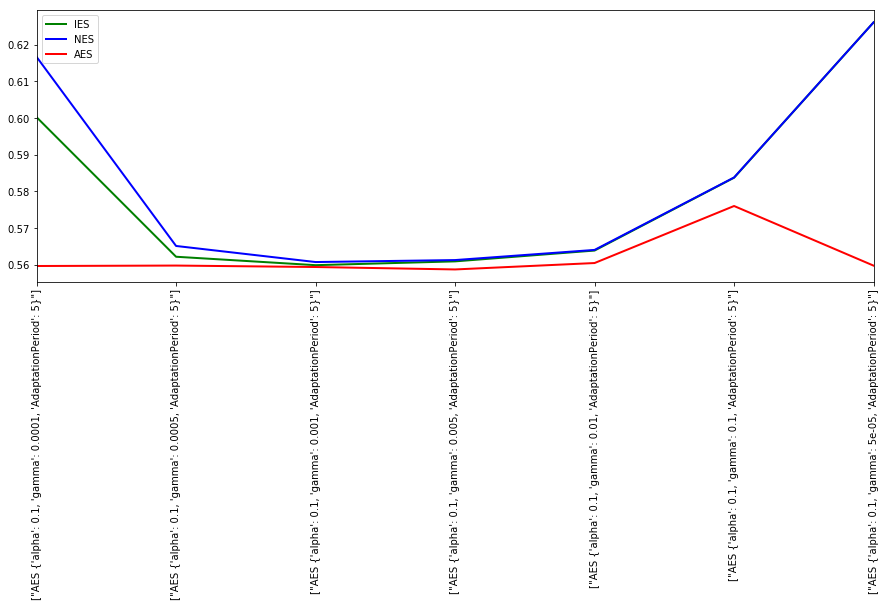

In [ ]:
# compare ES methods
QualityStr = pd.DataFrame(index = ts.columns, columns = sorted(FRC_TS.keys()))

for model in sorted(QualityStr.columns):
    frc_ts = FRC_TS[model]
    QualityStr[model],_ = qualityMACAPE(ts, frc_ts)

QualityStr[sorted(QualityStr.columns)[14:21]].mean().plot(color='g', label='IES', figsize = (15, 5), linewidth=2)
QualityStr[sorted(QualityStr.columns)[21:]].mean().plot(color='b', label='NES', linewidth=2 )
ax = QualityStr[sorted(QualityStr.columns)[:7]].mean().plot(color='r', label='AES', linewidth=2 )
ax.set_xticklabels(np.reshape(np.asarray(QualityStr.columns[:7]), (1, 7)).T , rotation=90)
plt.legend()
# ax.set_xticklabels(df.C, rotation=90)

** Conclusion**: Adaptive ES has less loss (by optimal value of parameters) than other modifications ES  

In [ ]:
# Sort Quality
QualityStr[QualityStr.columns[:14]].mean().sort_values()

ES {'alpha': 0.1}     0.560255
ES {'alpha': 0.15}    0.560958
ES {'alpha': 0.2}     0.563810
ES {'alpha': 0.05}    0.564351
ES {'alpha': 0.4}     0.583668
AES gamma 0.00050     0.604509
AES gamma 0.00100     0.604864
AES gamma 0.00010     0.605832
AES gamma 0.00005     0.606053
AES gamma 0.00500     0.611565
ES {'alpha': 0.01}    0.612826
AES gamma 0.01000     0.617236
ES {'alpha': 0.7}     0.626007
AES gamma 0.10000     0.659694
dtype: float64

## Case when SES doesn't work

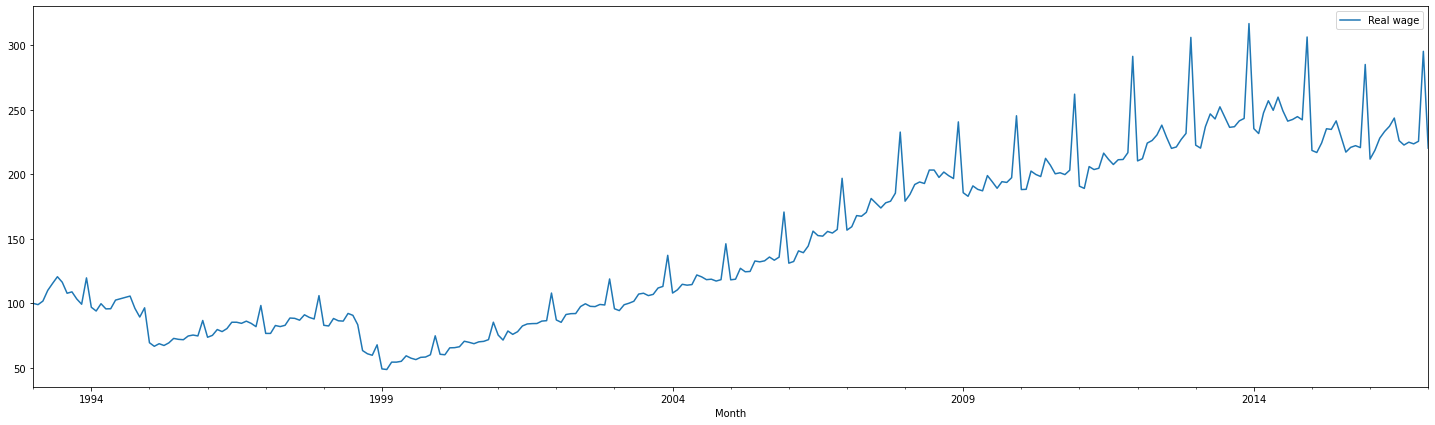

In [53]:
# Wage data in RF
wage = pd.read_csv('https://raw.githubusercontent.com/aromanenko/ATSF/main/data/monthly-wage.csv', sep=';', index_col= 0, parse_dates=True)
wage.plot(figsize=(25,7))

**Questions** 
    - Which charachteristic of TS can you mention so far?

Wage ts forecast with SES alpha =0.1

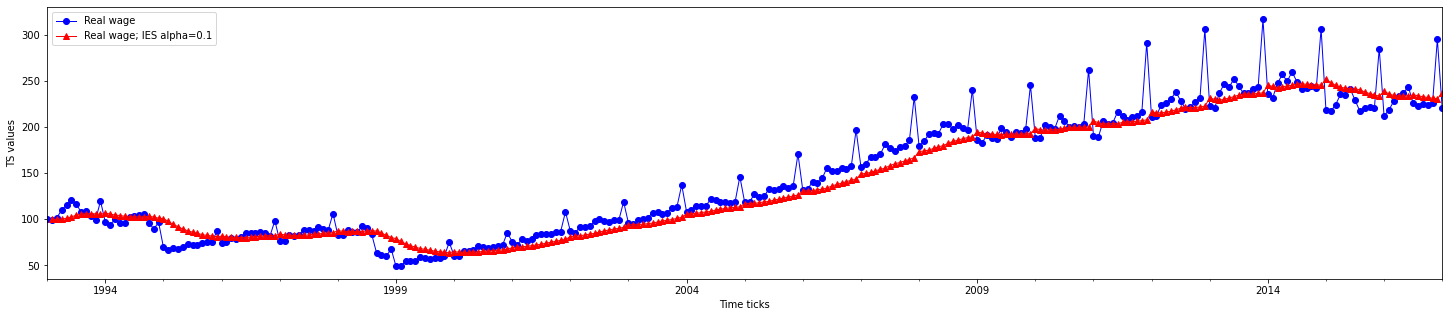

In [55]:
ESParamsArray = [{'alpha':0.1, 'AdaptationPeriod':10}]
FRC_WAGE = build_forecast(h=1, ts=wage, AlgName =  'SimpleExponentialSmoothing', AlgTitle='SES' ,ParamsArray = ESParamsArray)

plotTSForecast(wage.loc['1993-01-01':'2017-01-01'], FRC_WAGE[list(FRC_WAGE)[0]].loc['1993-01-01':'2017-01-01']
               , ts_num=0, alg_title='IES alpha=0.1')

**Question**
  * What indicates that forecast is inadequate (=there could be more proper forecastl)?

Search for the optimal $\alpha$ 

In [59]:
ALPHA = np.linspace(0.01,0.99,99)
ESParamsArray = [{'alpha':alpha, 'AdaptationPeriod':10} for alpha in ALPHA]
FRC_WAGE = build_forecast(h=1, ts=wage, AlgName =  'SimpleExponentialSmoothing', AlgTitle='SES' ,ParamsArray = ESParamsArray)

In [60]:
# compare ES parameters
QualityStr = pd.DataFrame(index = wage.columns, columns = FRC_WAGE.keys())

ix = wage.loc['1998-09-01':'2015-01-01'].index
for param_cntr in sorted(QualityStr.columns):
    frc_wage = FRC_WAGE[param_cntr]
    QualityStr[param_cntr],_ = qualityMAPE(wage.loc[ix], frc_wage.loc[ix])

QualityStr[QualityStr.columns].mean().sort_values()

SES {'alpha': 0.39, 'AdaptationPeriod': 10}                   0.058482
SES {'alpha': 0.4, 'AdaptationPeriod': 10}                    0.058486
SES {'alpha': 0.38, 'AdaptationPeriod': 10}                   0.058488
SES {'alpha': 0.41000000000000003, 'AdaptationPeriod': 10}    0.058502
SES {'alpha': 0.37, 'AdaptationPeriod': 10}                   0.058520
                                                                ...   
SES {'alpha': 0.05, 'AdaptationPeriod': 10}                   0.137595
SES {'alpha': 0.04, 'AdaptationPeriod': 10}                   0.159232
SES {'alpha': 0.03, 'AdaptationPeriod': 10}                   0.191038
SES {'alpha': 0.02, 'AdaptationPeriod': 10}                   0.238031
SES {'alpha': 0.01, 'AdaptationPeriod': 10}                   0.309603
Length: 99, dtype: float64

draw the forecast with optimial value $\alpha $

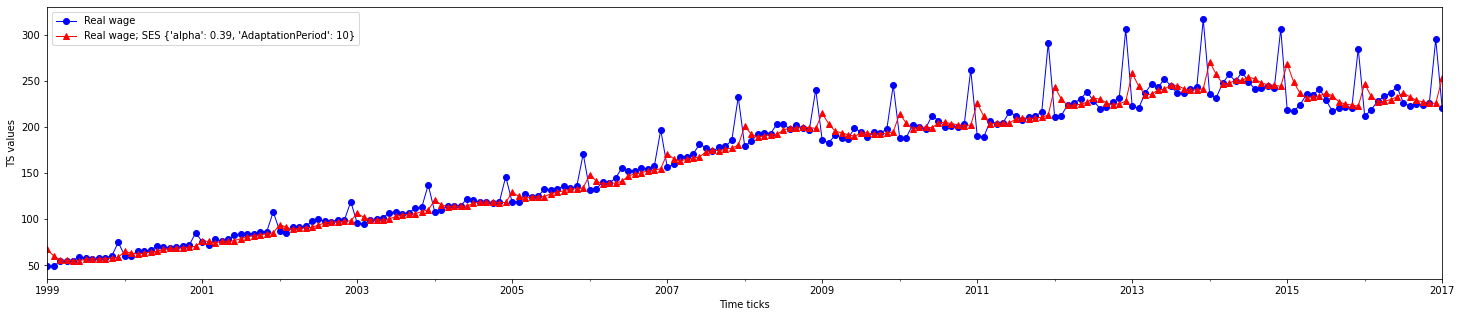

In [61]:
algName = QualityStr[QualityStr.columns].mean().sort_values().index[0]
plotTSForecast(wage.loc['1999-01-01':'2017-01-01'], FRC_WAGE[algName].loc['1999-01-01':'2017-01-01']
               , ts_num=0, alg_title=algName)

**Question**
    * Is forecast still inadequate?

Calculate loss of the forecast of TS in [02.2016, 01.2017]

In [62]:
qualityMAPE(wage.loc['2016-02-01':'2017-01-01'], FRC_WAGE[algName].loc['2016-02-01':'2017-01-01'])[0]

Real wage    0.056638
dtype: float64

SES to Yearly Wage Data

In [63]:
# Aggregate original TS by Years
wage_year = wage.resample("12MS").sum()[:-1] # cut 2017 year
wage_year[-4:]

,Real wage
Month,
2013-01-01,2940.9
2014-01-01,3007.2
2015-01-01,2766.7
2016-01-01,2790.6


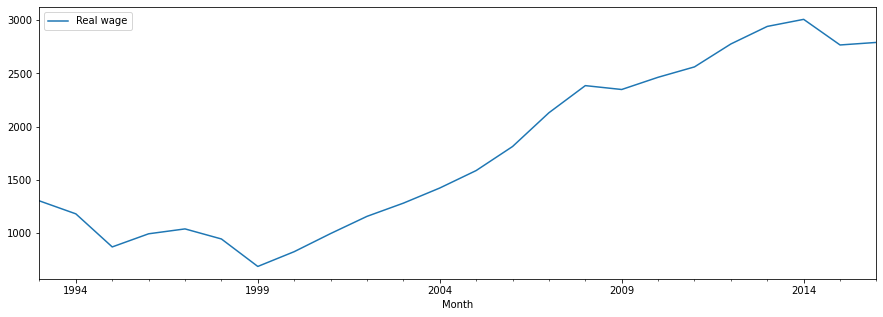

In [64]:
wage_year.plot(figsize=(15,5))

Search of optimal $\alpha$ for aggregated data

In [66]:
ALPHA = np.linspace(0.01,1,100)
ESParamsArray = [{'alpha':alpha, 'AdaptationPeriod':10} for alpha in ALPHA]
FRC_WAGE_YEAR = build_forecast(h=1, ts=wage_year, AlgName =  'SimpleExponentialSmoothing', AlgTitle='IES'
                              ,ParamsArray = ESParamsArray, step='12MS')

In [68]:
# compare ES parameters
QualityStr = pd.DataFrame(index = wage_year.columns, columns = FRC_WAGE_YEAR.keys())

ix = wage_year.loc['1999-01':'2010-01'].index
for param_cntr in sorted(QualityStr.columns):
    frc_wage = FRC_WAGE_YEAR[param_cntr]
    QualityStr[param_cntr],_ = qualityMAPE(wage_year.loc[ix], frc_wage.loc[ix])

QualityStr[QualityStr.columns].mean().sort_values()[:5]

IES {'alpha': 1.0, 'AdaptationPeriod': 10}                   0.132986
IES {'alpha': 0.99, 'AdaptationPeriod': 10}                  0.133505
IES {'alpha': 0.98, 'AdaptationPeriod': 10}                  0.134027
IES {'alpha': 0.97, 'AdaptationPeriod': 10}                  0.134553
IES {'alpha': 0.9600000000000001, 'AdaptationPeriod': 10}    0.135084
dtype: float64

Forecast with optimial value  $\alpha$

MAPE: Real wage    0.047746
dtype: float64


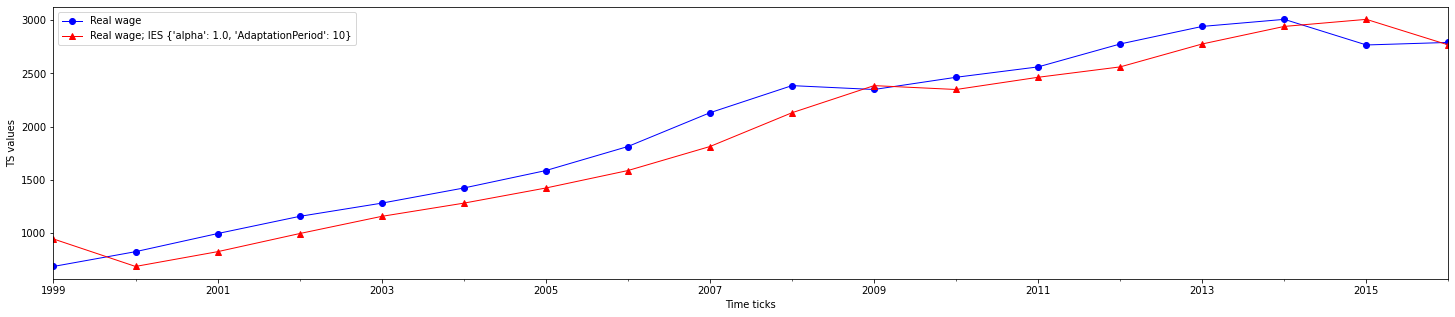

In [69]:
algName = QualityStr[QualityStr.columns].mean().sort_values().index[0]
plotTSForecast(wage_year.loc['1999-01-01':'2016-01-01'], FRC_WAGE_YEAR[algName].loc['1999-01-01':'2016-01-01']
               , ts_num=0, alg_title=algName)

print('MAPE: %s' % qualityMAPE(wage_year.loc['2015-01-01':'2016-01-01'], FRC_WAGE_YEAR[algName].loc['2015-01-01':'2016-01-01'])[0])

**Remember**
   - Empirical rules:

  if $\alpha^*\in(0,0.3)$ the series is stationary, ES works;

  if $\alpha^*\in(0.3,1)$ the series is non-stationary, we need a trend model.

# Prophet vs Simple Exponential Smoothing

In [103]:
from copy import deepcopy
quality_wholehist1 = deepcopy(quality_wholehist)

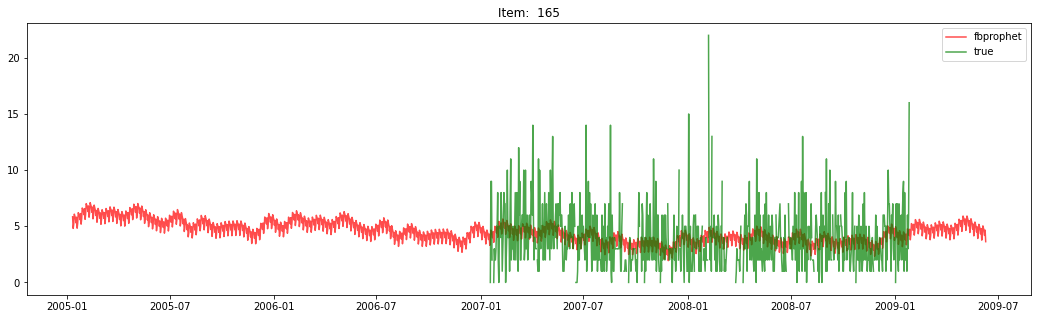

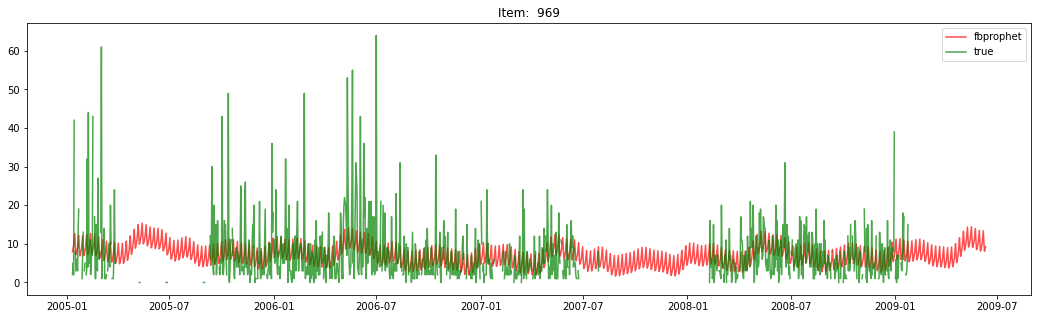

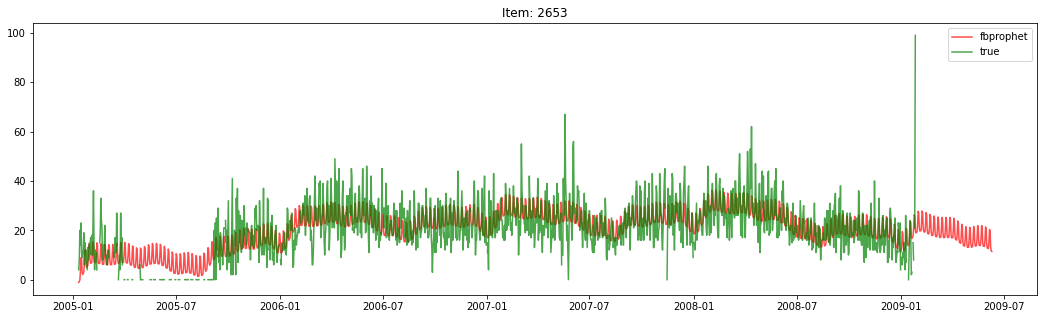

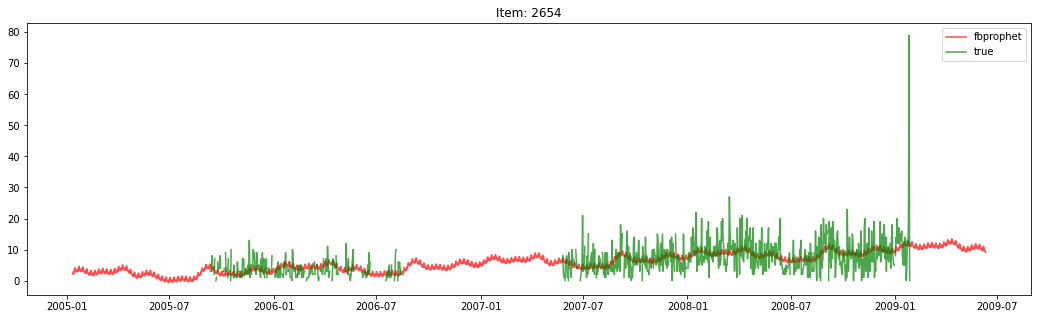

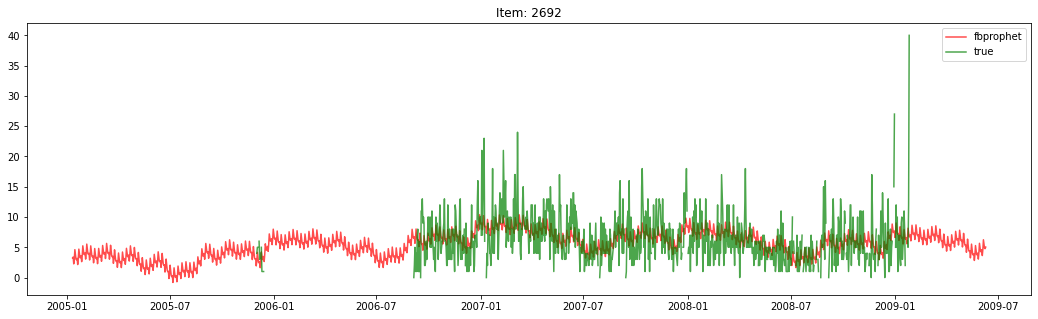

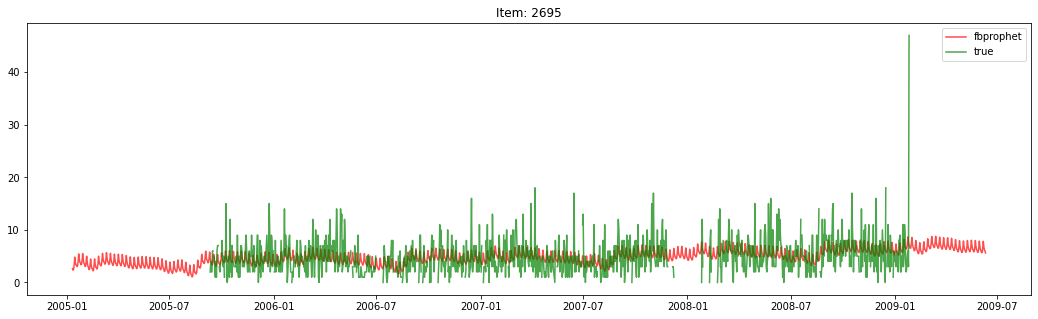

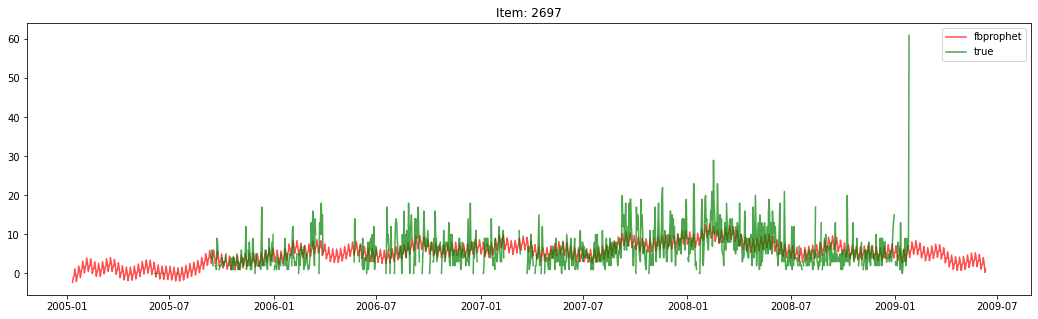

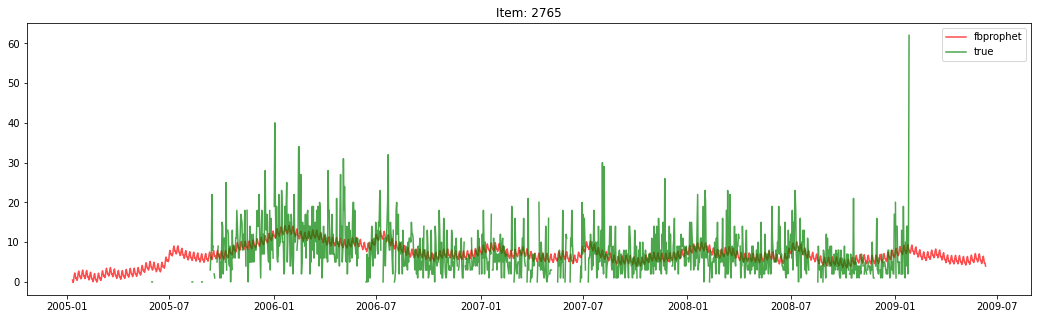

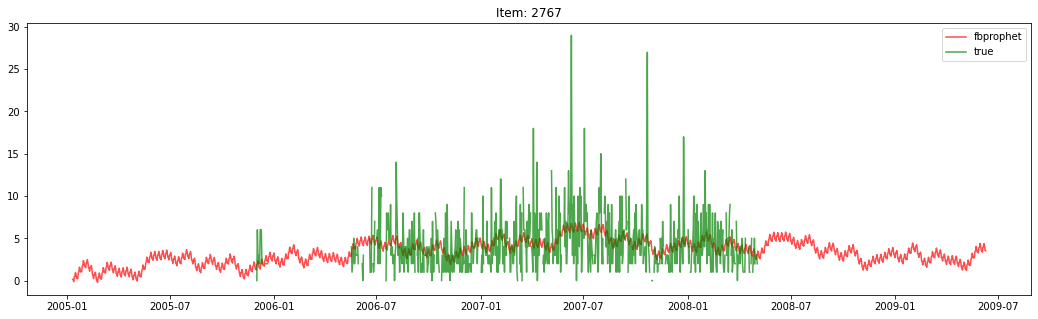

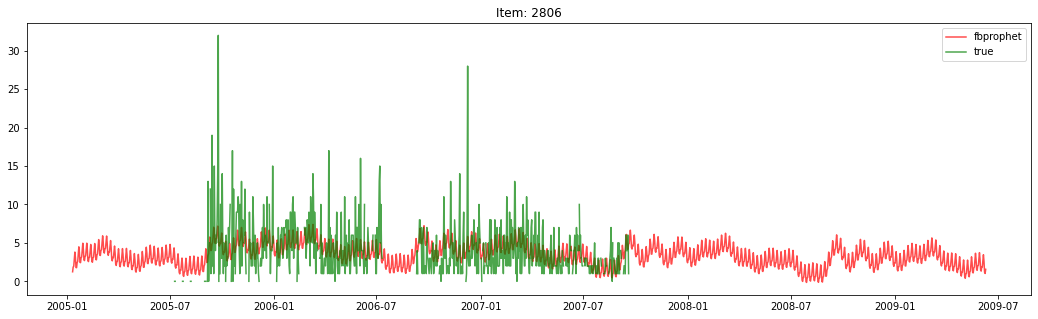

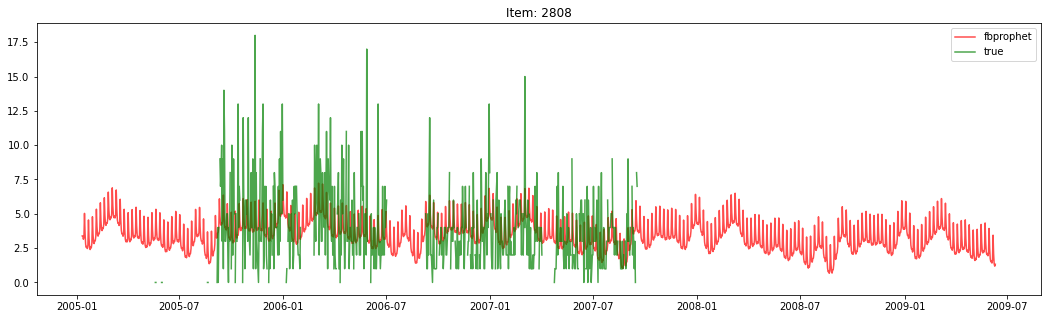

In [104]:
from fbprophet import Prophet

#suppressing the info logs
import logging
logging.getLogger('fbprophet').setLevel(logging.ERROR)

for col in ts.columns:
    #creating a dataframe that fbprophet requires
    df = pd.DataFrame(ts[col])
    df['ds'] = df.index
    df.columns = ['y', 'ds']
    
    #making predictions
    m = Prophet()
    m.fit(df)
    #'make_future_dataframe' parameter decides how far into the future we're looking
    future = m.make_future_dataframe(100)
    forecast = m.predict(future)
    
    #plotting the results
    plt.figure(figsize=(18,5))
    plt.plot(forecast['ds'], forecast['yhat'], color='red', alpha=0.7, label='fbprophet')
    plt.plot(df['y'], color='green', alpha=0.7, label='true')
    quality_wholehist1.loc[col, 'FBP'],_ = qualityMAPE(df['y'], forecast.set_index('ds').loc[ts.index]['yhat'])
    plt.title(col)
    plt.legend()
    plt.show();

In [107]:
# components of fbprophet model: there are many of them
#  forecast

Text(0, 0.5, 'MAPE')

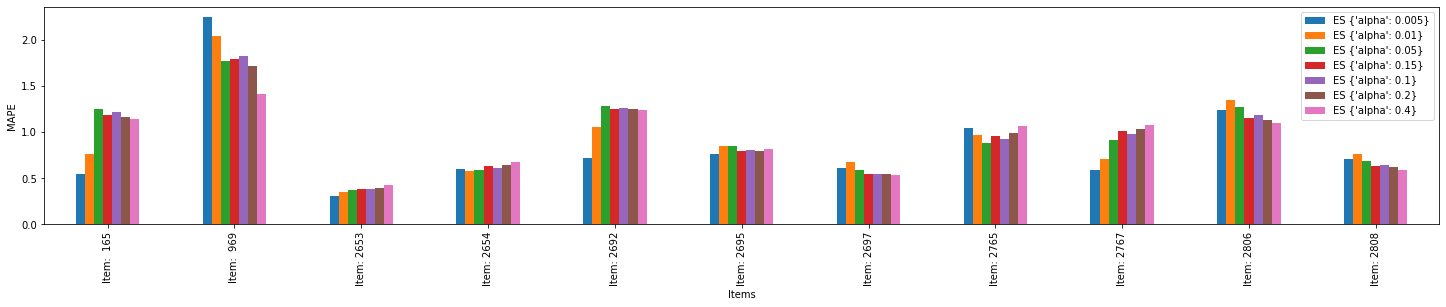

In [140]:
# generate forecast with SES for h = 100 next days after fs_start_dt
fs_start_dt = '07-01-2007'
h = 100

ALPHA = [0.4, 0.2, .15, 0.1, 0.05, 0.01, 0.005]
ESParamsArray = [{'alpha':alpha} for alpha in ALPHA]
FRC_TS = build_forecast(h=h, ts=ts[:fs_start_dt], AlgName =  'SimpleExponentialSmoothing', AlgTitle='ES' ,ParamsArray = ESParamsArray)


quality_100days = pd.DataFrame(index = ts.columns, columns = FRC_TS.keys())

# Quality within first 100 steps after fs_start_dt
for model in quality_100days.columns:
    frc_ts = FRC_TS[model]
    for ts_num in ts.columns:
        ix = pd.date_range(pd.to_datetime(fs_start_dt), pd.to_datetime(fs_start_dt)+timedelta(h) )
        quality_100days[model][ts_num],_ = qualityMAPE(ts[ts_num].loc[ix], frc_ts[ts_num].loc[ix])

# ax = quality_100days[sorted(quality_100days.columns)].plot.bar(figsize = (25,4))
# ax.set_xlabel("Items")
# ax.set_ylabel("MAPE")

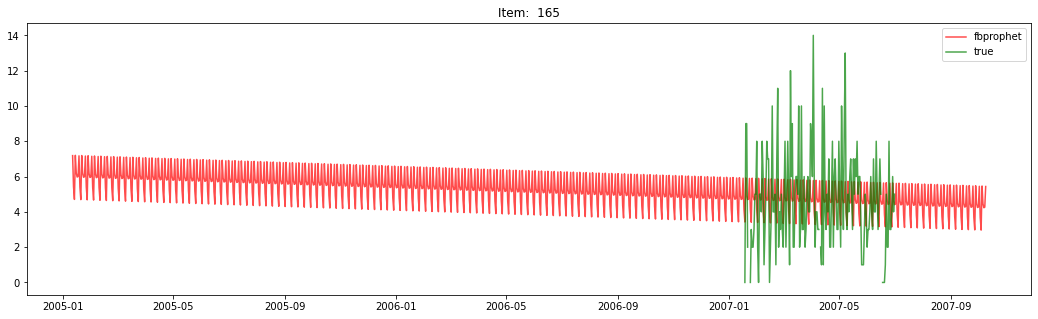

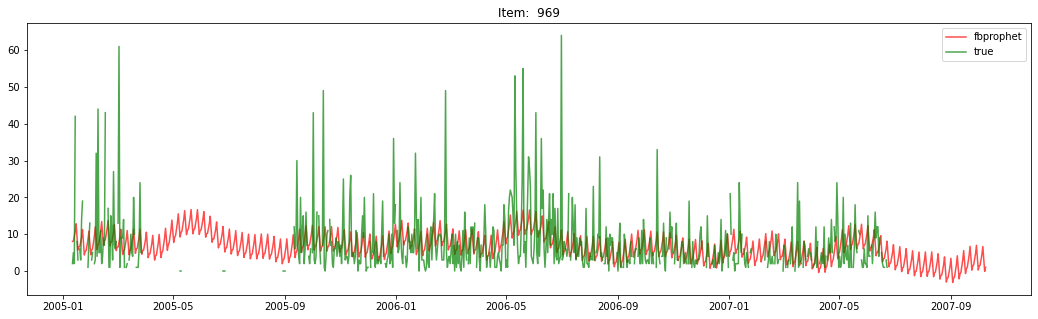

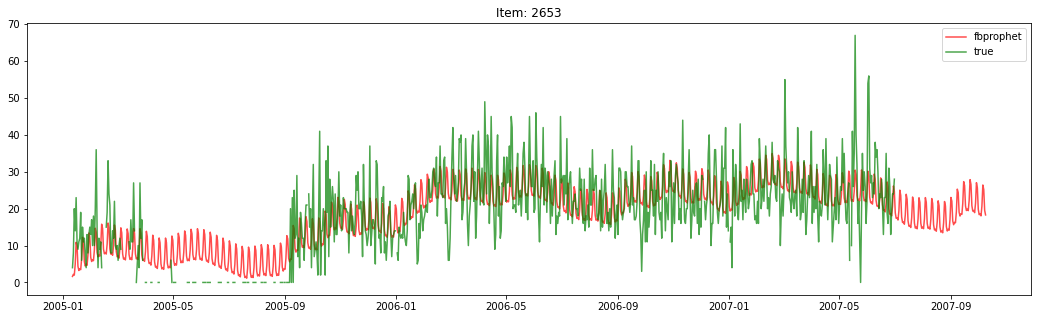

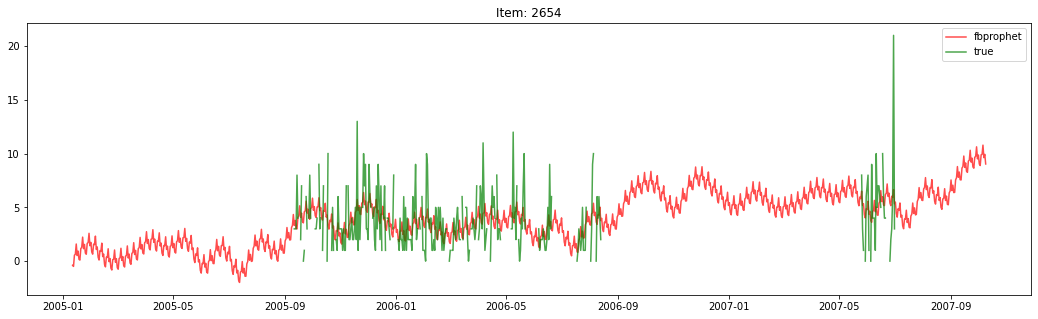

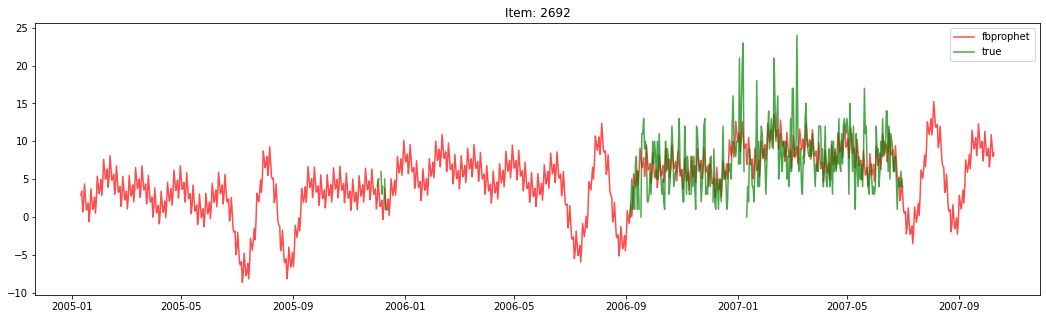

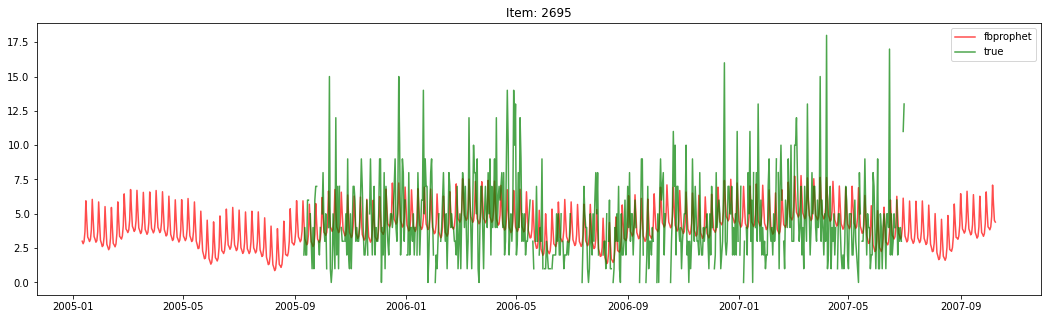

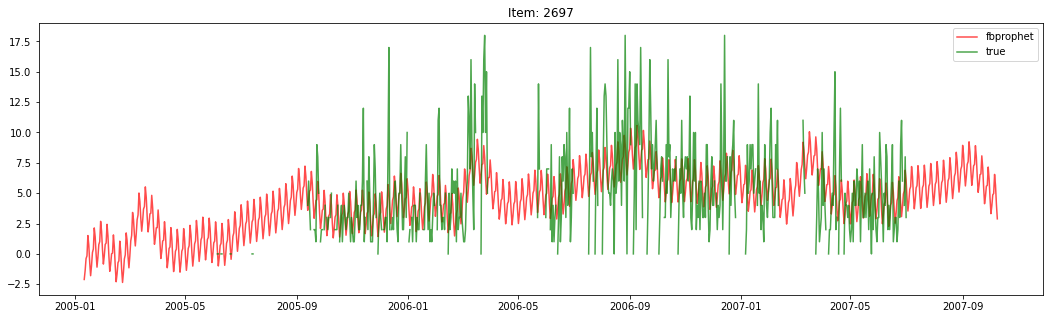

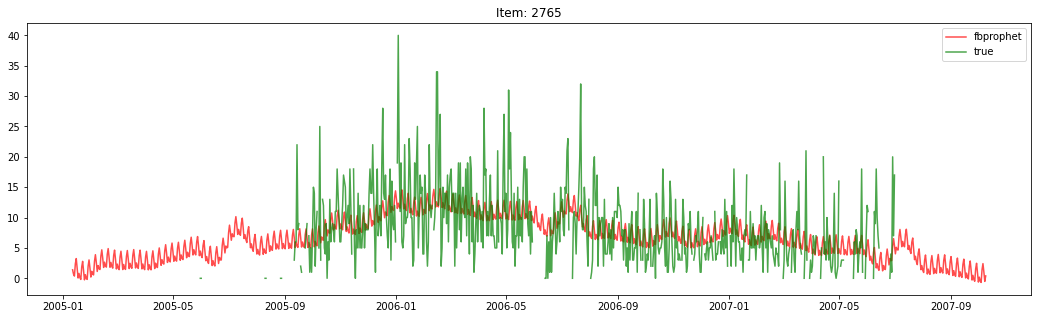

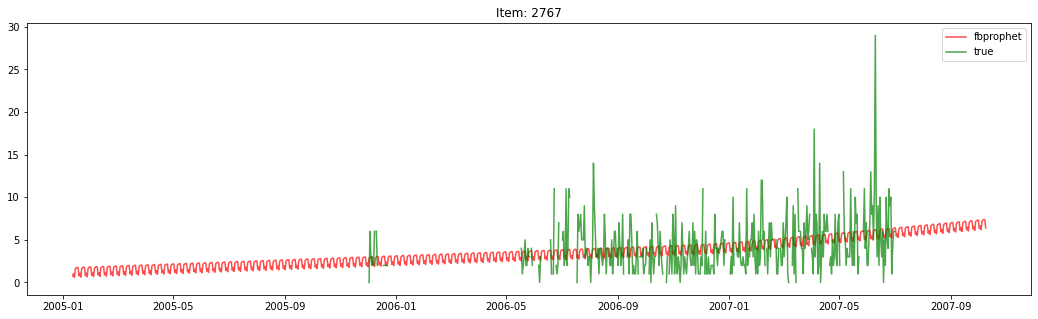

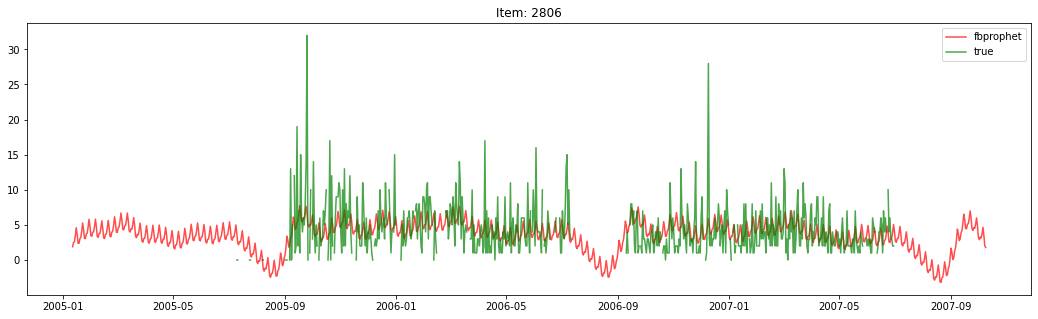

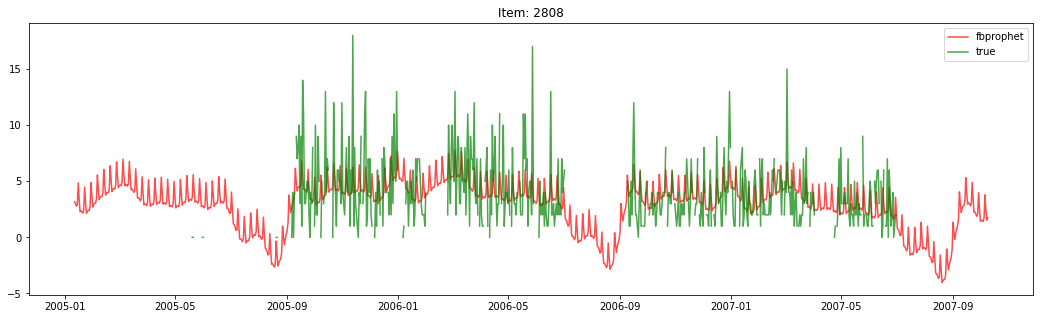

In [141]:
# generate forecast since fs_start_dt
for col in ts.columns:
    #creating a dataframe that fbprophet requires
    df = pd.DataFrame(ts.loc[:fs_start_dt, col])
    df['ds'] = ts[:fs_start_dt].index
    df.columns = ['y', 'ds']
    
    #making predictions
    m = Prophet()
    m.fit(df)
    #'make_future_dataframe' parameter decides how far into the future we're looking
    future = m.make_future_dataframe(100)
    forecast = m.predict(future)
    
    #plotting the results
    plt.figure(figsize=(18,5))
    plt.plot(forecast['ds'], forecast['yhat'], color='red', alpha=0.7, label='fbprophet')
    plt.plot(df['y'], color='green', alpha=0.7, label='true')
    quality_100days.loc[col, 'FBP'],_ = qualityMAPE(ts.loc[fs_start_dt:, col], forecast.set_index('ds').loc[fs_start_dt:, 'yhat'])
    plt.title(col)
    plt.legend()
    plt.show();

Text(0, 0.5, 'MAPE')

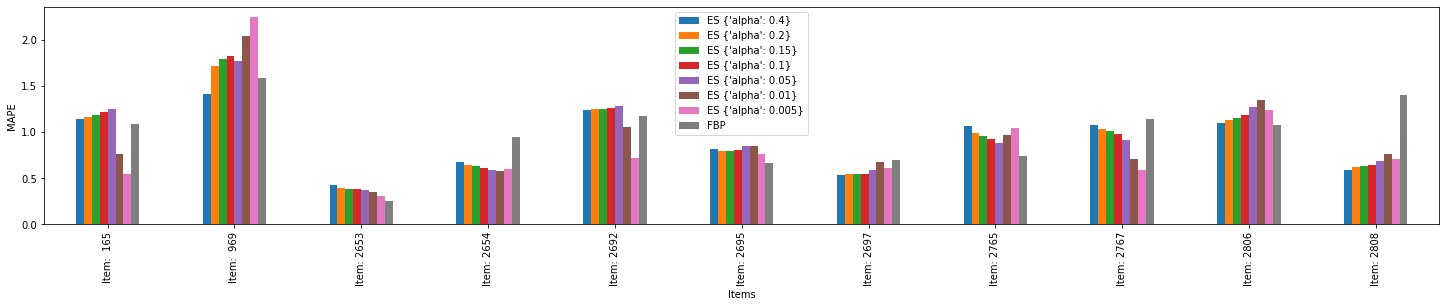

In [143]:
ax = quality_100days.plot.bar(figsize = (25,4))
ax.set_xlabel("Items")
ax.set_ylabel("MAPE")

# Materials
* Лукишн Ю.П. Адаптивные методы краткосрочного прогнозирования временных рядов. Финансы и статистика. 2003, главы 1,4,5,7.